# Book Recommendation Demo

## Setup

Let's get some libraries in here:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

And LensKit pieces:

In [2]:
from lenskit import topn, batch, sharing
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender
from lenskit.algorithms.basic import Popular
from lenskit.algorithms.item_knn import ItemItem
from lenskit.algorithms.als import ImplicitMF

Set up logging:

In [3]:
from lenskit.util import log_to_notebook
log_to_notebook()

[   INFO] lenskit.util.log notebook logging configured


And initialize the RNG:

In [4]:
import seedbank
seedbank.initialize(20230215)

[   INFO] seedbank initialized root seed SeedSequence(
    entropy=20230215,
)


SeedSequence(
    entropy=20230215,
)

## Loading Data

We need to load data. This file is pre-filtered for us; we have also pre-split the data with anotehr script.

In [5]:
train = pd.read_parquet('data/action-core/eval-train.parquet', columns=['user', 'item'])
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25940001 entries, 0 to 25952500
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   user    int32
 1   item    int32
dtypes: int32(2)
memory usage: 395.8 MB


In [6]:
test = pd.read_parquet('data/action-core/eval-test.parquet', columns=['user', 'item'])
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12500 entries, 3326749 to 24742621
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   user    12500 non-null  int32
 1   item    12500 non-null  int32
dtypes: int32(2)
memory usage: 195.3 KB


Grab work titles:

In [7]:
works = pd.read_parquet('data/gr-work-info.parquet', columns=['work_id', 'title', 'pub_year'])
works.head()

,work_id,title,pub_year
0,5400751,W. C. Fields: A Life on Film,1984.0
1,1323437,Good Harbor,2001.0
2,8948723,None,1987.0
3,6243154,Best Friends Forever,2009.0
4,278577,Runic Astrology: Starcraft and Timekeeping in ...,1990.0


The ratings are for *items*, which may be works or they may be books that don't have a work. Convert work IDs to item IDs:

In [8]:
works['item'] = works['work_id'] + 400_000_000
works.set_index('item', inplace=True)
works

,work_id,title,pub_year
item,,,
405400751,5400751,W. C. Fields: A Life on Film,1984.0
401323437,1323437,Good Harbor,2001.0
408948723,8948723,None,1987.0
406243154,6243154,Best Friends Forever,2009.0
400278577,278577,Runic Astrology: Starcraft and Timekeeping in ...,1990.0
...,...,...,...
425313618,25313618,None,2002.0
425365816,25365816,None,2013.0
403115103,3115103,This Sceptred Isle: 1837-1901,1996.0


And get item statistics:

In [10]:
item_stats = train.groupby('item')['user'].agg(['count']).rename(columns={'count': 'nratings'})
item_stats

,nratings
item,
400000087,350
400000098,363
400000104,444
400000114,571
400000115,3283
...,...
457733739,119
516148398,392
523555246,172


And look at the popularity curve for a bit of statistics:

<Axes: xlabel='nratings', ylabel='Proportion'>

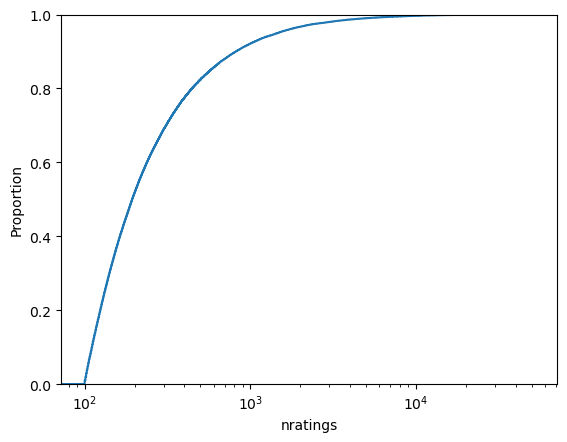

In [11]:
sns.ecdfplot(x=item_stats['nratings'], log_scale=True)

How many users and items do we have?

In [13]:
train[['user', 'item']].nunique()

user    309781
item     55398
dtype: int64

## Data Preparation

We have already prepared train-test.

Now we want the list of test user IDs so we can generate recommendations.

In [14]:
test_users = test['user'].unique()
test_users

array([    79,     87,    305, ..., 869543, 870632, 874209], dtype=int32)

In [15]:
test

,user,item
3326749,79,406651006
5278248,79,420397129
5781213,79,402422333
4224759,79,402267189
5449630,79,402460920
...,...,...
23292774,874209,401110983
22906995,874209,402375385
23480514,874209,401355172
25116559,874209,401686217


## First Recommendations

Let's start with a super simple baseline - most popular:

In [16]:
pop = Popular()
pop = Recommender.adapt(pop)

In [17]:
pop.fit(train)

[   INFO] lenskit.algorithms.basic trained unrated candidate selector for 25940001 ratings


And get some recommendations - 100 per user:

In [18]:
N = 100
pop_recs = batch.recommend(pop, test_users, N)

[   INFO] binpickle.write pickled 963 bytes with 7 buffers
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch._recommend recommending with Popular for 2500 users (n_jobs=None)
[   INFO] lenskit.batch._recommend recommended for 2500 users in 10.20s


## Measuring Recommendations

Now we want to measure these recommendations.  We need RecListAnalysis:

In [19]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.hit, k=N)
rla.add_metric(topn.recall, k=N)
rla.add_metric(topn.recip_rank, k=N)
rla.add_metric(topn.ndcg, k=N)

And compute scores:

In [20]:
pop_scores = rla.compute(pop_recs, test, include_missing=True)
pop_scores.describe()

[   INFO] lenskit.topn analyzing 250000 recommendations (12500 truth rows)
[   INFO] lenskit.topn using rec key columns ['user']
[   INFO] lenskit.topn using truth key columns ['user']
[   INFO] lenskit.topn numbering truth lists
[   INFO] lenskit.topn numbering rec lists
[   INFO] lenskit.topn collecting metric results
[   INFO] lenskit.topn measured 2500 lists in  131ms
[   INFO] lenskit.topn filling in missing user info (2500 initial rows)


,nrecs,hit,recall,recip_rank,ndcg,ntruth
count,2500.0,2500.000000,2500.000000,2500.000000,2500.000000,2500.0
mean,100.0,0.416800,0.122160,0.051405,0.046875,5.0
std,0.0,0.493128,0.173485,0.150251,0.079601,0.0
min,100.0,0.000000,0.000000,0.000000,0.000000,5.0
25%,100.0,0.000000,0.000000,0.000000,0.000000,5.0
50%,100.0,0.000000,0.000000,0.000000,0.000000,5.0
75%,100.0,1.000000,0.200000,0.027976,0.059733,5.0
max,100.0,1.000000,1.000000,1.000000,0.564986,5.0


In [21]:
pop_scores.nlargest(5, 'ndcg')

,nrecs,hit,recall,recip_rank,ndcg,ntruth
user,,,,,,
261665,100,1.0,0.8,0.500000,0.564986,5
176164,100,1.0,0.8,0.500000,0.519513,5
674633,100,1.0,0.6,0.500000,0.511421,5
710905,100,1.0,1.0,0.333333,0.505711,5
659813,100,1.0,0.8,1.000000,0.482976,5


In [22]:
top_uid = pop_scores.nlargest(1, 'ndcg').index[0]
recs_u = pop_recs[pop_recs['user'] == top_uid]
recs_u

,item,score,user,rank
137100,441107568,52220.0,261665,1
137101,402792775,40496.0,261665,2
137102,416827462,39377.0,261665,3
137103,421825181,37553.0,261665,4
137104,413306276,35129.0,261665,5
...,...,...,...,...
137195,442942273,13209.0,261665,96
137196,403203964,13133.0,261665,97
137197,403295655,13070.0,261665,98
137198,402588213,12986.0,261665,99


In [23]:
test_u = test[test['user'] == top_uid].set_index('item').assign(rating=1)['rating']
test_u

item
403532896    1
402792775    1
416827462    1
402543657    1
402977639    1
Name: rating, dtype: int64

In [24]:
recs_u = recs_u.join(test_u, on='item')
recs_u.iloc[:10, :]

,item,score,user,rank,rating
137100,441107568,52220.0,261665,1,NaN
137101,402792775,40496.0,261665,2,1.0
137102,416827462,39377.0,261665,3,1.0
137103,421825181,37553.0,261665,4,NaN
137104,413306276,35129.0,261665,5,NaN
137105,400878368,34887.0,261665,6,NaN
137106,425491300,33261.0,261665,7,NaN
137107,403364505,32861.0,261665,8,NaN
137108,413155899,30894.0,261665,9,NaN
137109,402402163,29043.0,261665,10,NaN


In [25]:
recs_u['discount'] = np.reciprocal(np.log2(np.maximum(recs_u['rank'], 2)))
recs_u

,item,score,user,rank,rating,discount
137100,441107568,52220.0,261665,1,NaN,1.000000
137101,402792775,40496.0,261665,2,1.0,1.000000
137102,416827462,39377.0,261665,3,1.0,0.630930
137103,421825181,37553.0,261665,4,NaN,0.500000
137104,413306276,35129.0,261665,5,NaN,0.430677
...,...,...,...,...,...,...
137195,442942273,13209.0,261665,96,NaN,0.151861
137196,403203964,13133.0,261665,97,NaN,0.151517
137197,403295655,13070.0,261665,98,NaN,0.151178
137198,402588213,12986.0,261665,99,NaN,0.150844


In [26]:
dcg = np.sum(recs_u.iloc[:10]['rating'] * recs_u.iloc[:10]['discount'])
dcg

1.6309297535714575

In [27]:
ideal = test_u.sort_values(ascending=False)
ideal

item
403532896    1
402792775    1
416827462    1
402543657    1
402977639    1
Name: rating, dtype: int64

In [28]:
ideal_disc = np.reciprocal(np.log2(np.maximum(np.arange(5) + 1, 2)))
ideal_disc

array([1.        , 1.        , 0.63092975, 0.5       , 0.43067656])

In [29]:
ideal_dcg = np.sum(ideal * ideal_disc)
ideal_dcg

3.5616063116448506

In [30]:
dcg / ideal_dcg

0.45791971679717963

## Another Algorithm

Now let's get some real recommendations - item-item *k*-NN in implicit feedback mode:

In [31]:
iknn = ItemItem(20, feedback='implicit', min_nbrs=2, min_sim=0.01, save_nbrs=5000)
iknn = Recommender.adapt(iknn)

In [32]:
iknn = iknn.fit(train, save_nbrs=10000)
None # keep ipython from saving a reference to the model

[   INFO] lenskit.util.debug opening self DLL
[   INFO] lenskit.util.debug numba threading layer: tbb
[   INFO] lenskit.util.debug Numba and BLAS both using TBB - good
[   INFO] lenskit.algorithms.item_knn [4.74s] made sparse matrix for 55398 items (25940001 ratings from 309781 users)
[   INFO] lenskit.algorithms.item_knn [6.52s] normalized rating matrix columns
[   INFO] lenskit.algorithms.item_knn [6.63s] computing similarity matrix
[   INFO] lenskit.algorithms.item_knn [7.63s] splitting 55398 items (25940001 ratings) into 56 blocks
[   INFO] lenskit.algorithms.item_knn [7.81s] computing similarities
[   INFO] lenskit.algorithms.item_knn 43.42s] computed 265948021 similarities for 55398 items in 56 blocks
[   INFO] lenskit.algorithms.item_knn 43.84s] sorting similarity matrix with 265948021 entries
[   INFO] lenskit.algorithms.item_knn 48.85s] got neighborhoods for 55398 of 55398 items
[   INFO] lenskit.algorithms.item_knn 48.85s] computed 265948021 neighbor pairs
[   INFO] lenskit.a

Can we get some recommendations?

In [33]:
iknn.recommend(test_users[0], 5)

,item,score
0,406651006,7.603953
1,442940024,7.504183
2,442940027,7.342818
3,402267189,7.292381
4,442940029,7.284626


Now generate recommendations:

In [34]:
iknn_recs = batch.recommend(iknn, test_users, N)

[   INFO] binpickle.write pickled 1212 bytes with 15 buffers
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch._recommend recommending with TopN/ItemItem(nnbrs=20, msize=5000) for 2500 users (n_jobs=None)
[   INFO] lenskit.batch._recommend recommended for 2500 users in 47.98s


And score them:

In [35]:
iknn_scores = rla.compute(iknn_recs, test, include_missing=True)
iknn_scores.describe()

[   INFO] lenskit.topn analyzing 250000 recommendations (12500 truth rows)
[   INFO] lenskit.topn using rec key columns ['user']
[   INFO] lenskit.topn using truth key columns ['user']
[   INFO] lenskit.topn numbering truth lists
[   INFO] lenskit.topn numbering rec lists
[   INFO] lenskit.topn collecting metric results
[   INFO] lenskit.topn measured 2500 lists in  159ms
[   INFO] lenskit.topn filling in missing user info (2500 initial rows)


,nrecs,hit,recall,recip_rank,ndcg,ntruth
count,2500.0,2500.00000,2500.000000,2500.000000,2500.000000,2500.0
mean,100.0,0.79000,0.339680,0.297052,0.197402,5.0
std,0.0,0.40739,0.266064,0.387059,0.202913,0.0
min,100.0,0.00000,0.000000,0.000000,0.000000,5.0
25%,100.0,1.00000,0.200000,0.014286,0.046083,5.0
50%,100.0,1.00000,0.400000,0.076923,0.125489,5.0
75%,100.0,1.00000,0.600000,0.500000,0.305530,5.0
max,100.0,1.00000,1.000000,1.000000,1.000000,5.0


## And a Third

Implicit ALS.

In [36]:
ials = ImplicitMF(100, reg=(4, 0.3), weight=25, use_ratings=False)
ials = Recommender.adapt(ials)
ials.fit(train)
print(ials)

[   INFO] lenskit.algorithms.als [5.01s] training implicit MF model with ALS for 100 features
[   INFO] lenskit.algorithms.als have 25940001 observations for 309781 users and 55398 items
[   INFO] lenskit.algorithms.als [24.53s] finished epoch 0 (|ΔP|=713.877, |ΔQ|=1388.439)
[   INFO] lenskit.algorithms.als [31.97s] finished epoch 1 (|ΔP|=36.110, |ΔQ|=475.924)
[   INFO] lenskit.algorithms.als [39.81s] finished epoch 2 (|ΔP|=20.729, |ΔQ|=332.427)
[   INFO] lenskit.algorithms.als [46.06s] finished epoch 3 (|ΔP|=14.400, |ΔQ|=230.641)
[   INFO] lenskit.algorithms.als [53.17s] finished epoch 4 (|ΔP|=10.176, |ΔQ|=143.085)
[   INFO] lenskit.algorithms.als [59.81s] finished epoch 5 (|ΔP|=7.550, |ΔQ|=120.339)
[   INFO] lenskit.algorithms.als 6.32s] finished epoch 6 (|ΔP|=5.835, |ΔQ|=93.126)
[   INFO] lenskit.algorithms.als 14.14s] finished epoch 7 (|ΔP|=4.349, |ΔQ|=75.182)
[   INFO] lenskit.algorithms.als 20.27s] finished epoch 8 (|ΔP|=3.897, |ΔQ|=56.446)
[   INFO] lenskit.algorithms.als 29.29s

And make and score recs:

In [37]:
ials_recs = batch.recommend(ials, test_users, N)
ials_scores = rla.compute(ials_recs, test, include_missing=True)
ials_scores.describe()

[   INFO] binpickle.write pickled 1238 bytes with 9 buffers
[   INFO] lenskit.util.parallel setting up ProcessPoolExecutor w/ 4 workers
[   INFO] lenskit.batch._recommend recommending with TopN/als.ImplicitMF(features=100, reg=(4, 0.3), w=25) for 2500 users (n_jobs=None)
[   INFO] lenskit.batch._recommend recommended for 2500 users in 26.17s
[   INFO] lenskit.topn analyzing 250000 recommendations (12500 truth rows)
[   INFO] lenskit.topn using rec key columns ['user']
[   INFO] lenskit.topn using truth key columns ['user']
[   INFO] lenskit.topn numbering truth lists
[   INFO] lenskit.topn numbering rec lists
[   INFO] lenskit.topn collecting metric results
[   INFO] lenskit.topn measured 2500 lists in  258ms
[   INFO] lenskit.topn filling in missing user info (2500 initial rows)


,nrecs,hit,recall,recip_rank,ndcg,ntruth
count,2500.0,2500.000000,2500.000000,2500.000000,2500.000000,2500.0
mean,100.0,0.795200,0.334400,0.195014,0.156091,5.0
std,0.0,0.403636,0.258448,0.308233,0.163384,0.0
min,100.0,0.000000,0.000000,0.000000,0.000000,5.0
25%,100.0,1.000000,0.200000,0.012945,0.045076,5.0
50%,100.0,1.000000,0.400000,0.047619,0.105153,5.0
75%,100.0,1.000000,0.600000,0.200000,0.228195,5.0
max,100.0,1.000000,1.000000,1.000000,1.000000,5.0


## Overall Results

Let's see the results together!

In [40]:
all_scores = pd.concat({
    'Pop': pop_scores,
    'IKNN': iknn_scores,
    'IALS': ials_scores,
}, names=['Algorithm']).reset_index()
all_scores.head()

,Algorithm,user,nrecs,hit,recall,recip_rank,ndcg,ntruth
0,Pop,79,100,1.0,0.4,0.047619,0.107502,5
1,Pop,87,100,0.0,0.0,0.000000,0.000000,5
2,Pop,305,100,0.0,0.0,0.000000,0.000000,5
3,Pop,585,100,1.0,0.6,0.025000,0.141304,5
4,Pop,590,100,0.0,0.0,0.000000,0.000000,5


In [47]:
score_wide = all_scores.melt(id_vars=['Algorithm', 'user'], value_vars=['hit', 'recip_rank', 'ndcg'], var_name='Metric')
score_wide.head()

,Algorithm,user,Metric,value
0,Pop,79,hit,1.0
1,Pop,87,hit,0.0
2,Pop,305,hit,0.0
3,Pop,585,hit,1.0
4,Pop,590,hit,0.0


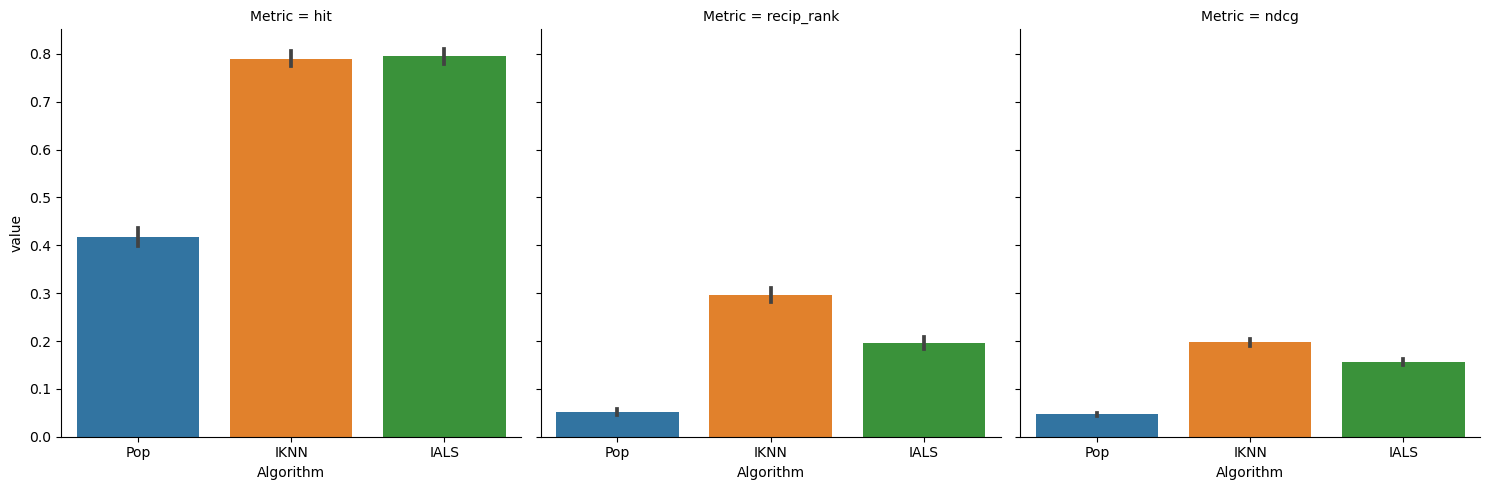

In [50]:
sns.catplot(data=score_wide, x='Algorithm', y='value', col='Metric', kind='bar')